In [112]:
import sys
sys.path.insert(0,'..')
#put path to optimusprimal git repo
sys.path.insert(0,'../../Optimus-Primal')
import optimusprimal.prox_operators as prox_operators
import optimusprimal.linear_operators as linear_operators
import optimusprimal.primal_dual as primal_dual
import faradaydreams.measurement_operator as measurement_operator
import faradaydreams.models as models
import faradaydreams.plot_spectrum as plot_spectrum
import faradaydreams.convex_solvers as solvers
import numpy as np
import matplotlib.pyplot as plt

This next bit of code sets up the parameters for the observation. The samples in frequency $\nu$, which determine the samples in $\lambda^2$. The big issue here is channgel width $\Delta \nu$ in frequency is constant, but $\Delta \lambda^2$ is not.

In [113]:
c = 2.92 * 10**8 #speed of light m/s
m_size = 200 #numbr of channels
ISNR = 20. #signal to noise ratio of input noise
freq0 =  np.linspace(400, 1400, m_size) * 10**6 # frequency coverage
dfreq = np.abs(freq0[1] - freq0[0]) # channel width
lambda2 = (c/freq0)**2 #wavelength^2 coverage
lambda1 = np.sqrt(lambda2) # wavelength coverage
dlambda2 = (c/(freq0 - dfreq/2.))**2 - (c/(freq0 + dfreq/2.))**2 #channel width in wavelength squared.
phi_max, phi_min, dphi = measurement_operator.phi_parameters(lambda2, dlambda2) #sensitivity estiamtes given coverage
phi = np.arange(-1e4, 1e4, dphi) # range in rad/m^2 to do reconstruction of signal
weights = np.ones(m_size) #choosing flat noise
rm_max = np.min([500, phi_max]) #only for plotting

2020-05-07 23:45:13,913 - Faraday Dreams - INFO - Phi resolution 1.8765246762994936 rad/m^2.
2020-05-07 23:45:13,914 - Faraday Dreams - INFO - phi max range is 3202.1279931609656 rad/m^2.
2020-05-07 23:45:13,915 - Faraday Dreams - INFO - phi min range is 74.67978862533752 rad/m^2.


### Constructing the model
Below we construct a ground truth Faraday Depth, this can be delta functions, box functions, or gaussian functions.

In [114]:
x_true = np.zeros(phi.shape) * 0j #zero model of signal

In [115]:
# amplitudes = [1, 2, 4] jy, locations = [-40, 25, 0], polarization angles = [0, np.pi/5, -np.pi/3] radians
x_true += models.deltas(phi, [1, 2, 4],[-400, -40, 25], [0, np.pi/5, -np.pi/3]) 

In [116]:
# amplitude = 1 jy, width = 10 rad/m^2, location = 50 rad/m^2, polarization angle = 0 radians
#x_true += models.box(phi, 1, 100, 200, 0)

In [117]:
# amplitude = 1 jy, width = 10 rad/m^2, location = 50 rad/m^2, polarization angle = 0 radians
x_true += models.gaussian(phi, 1, 10, 50, 0)

### Constructing the measurement matrix
The measurement matrix is determined by the following sum: 
$$P(\lambda^2_p) = \sum_{k=0}^N P(\phi_k) a(\lambda^2_p, \phi_k) {\rm e}^{2 i \lambda^2_p \phi_k}\Delta \phi_k$$
where $P$ is the complex polarization signal. $a$ is the impact of channel averaging (it has a constant value of 1 when there is no averaging). It is a Fourier series between $\lambda^2$ and $\phi$.

We can write this as $$\mathbf{y} = \mathbf{\mathsf{\Phi}}\mathbf{x}$$ since it is a system of linear equations.

In [118]:
# measurement operator with channel averaging
m_op_right = measurement_operator.faraday_operator(lambda2, phi, weights, dlambda2)
m_op_wrong = measurement_operator.faraday_operator(lambda2, phi, lambda2* 0 + 1)
#switch to see how important channel averaging is
m_op = m_op_right

Below we also create a version (for comparing no channel averaging) where $a(\lambda^2_p, \phi_k) = 1$

In [139]:
# measurement operator without channel averaging
lambda2_high_res = np.linspace(np.min(lambda2), np.max(lambda2), 1024)
lambda1_high_res = np.sqrt(lambda2_high_res)
m_op_no_averaging = measurement_operator.faraday_operator(lambda2_high_res, phi, lambda2_high_res * 0 + 1)

We calculate our simulated measurements $y$ with added noise.

In [140]:
# simulate measurement process
y0 = m_op_right.dir_op(x_true) 

In [141]:
# add iid noise to measurements
sigma = 10**(-ISNR/20.)  * np.linalg.norm(y0) * 1./ np.sqrt(m_size)
y = (y0 + np.random.normal(0, sigma, m_size) + 1j * np.random.normal(0, sigma, m_size)) * weights

Below we plot our measured signal in $\lambda^2$ (wavelength squared $m^2$) with and without channel averaging (top panel), and compare the absolute value of the measured signal in $\phi$ (Faraday Depth, rad/m$^2$) against the ground truth (bottom panel). 

The missing Fourier coefficients in $\lambda^2$ make the blue curve very different from the original (yellow).

(-500.0, 500.0)

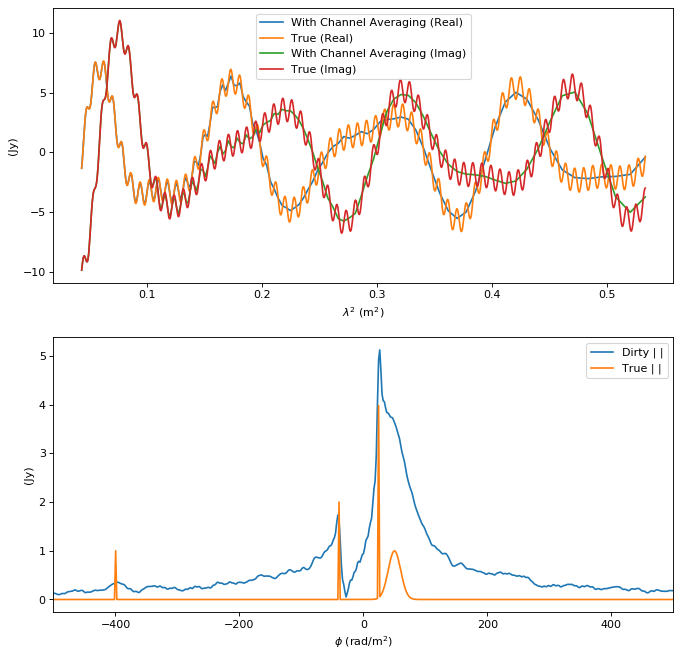

In [142]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), dpi=80)
ax[0].plot(lambda2, np.real(y0))
ax[0].plot(lambda2_high_res, np.real(m_op_no_averaging.dir_op(x_true)))
ax[0].plot(lambda2, np.imag(y0))
ax[0].plot(lambda2_high_res, np.imag(m_op_no_averaging.dir_op(x_true)))

ax[0].set_xlabel(r"$\lambda^2$ (m$^2$)")
ax[0].set_ylabel(r"(Jy)")
ax[0].legend(["With Channel Averaging (Real)", "True (Real)", "With Channel Averaging (Imag)", "True (Imag)"])
ax[1].plot(phi, np.abs(m_op.adj_op(y)) * 1./len(y))
ax[1].plot(phi, np.abs(x_true))
ax[1].legend(["Dirty | |", "True | |", "Solution | |"])
ax[1].set_xlabel(r"$\phi$ (rad/m$^2$)")
ax[1].set_ylabel(r"(Jy)")
ax[1].set_xlim([-rm_max, rm_max])

You can ignore this next cell for now, but it is needed for the algorithm

In [143]:
nu, sol = linear_operators.power_method(m_op, phi* 0 + 1, 1e-4)#estimate stepsize for algo (largest eigen value of measurement matrix)

2020-05-08 00:03:36,351 - Optimus Primal - INFO - Starting Power method
2020-05-08 00:03:36,358 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-05-08 00:03:36,376 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2020-05-08 00:03:36,398 - Optimus Primal - INFO - [Power Method] iter = 21, tol = 0.0
2020-05-08 00:03:36,419 - Optimus Primal - INFO - [Power Method] iter = 31, tol = 0.0
2020-05-08 00:03:36,431 - Optimus Primal - INFO - [Power Method] Converged with iter = 38, tol = 9.020701845595066e-05


Below you can choose assumptions about how to fit the true signal. You can choose wavelets or not (dirac is no wavelets). I suggest no wavelets for now

In [144]:
#choose basis for enforce sparisty (dirac seems to be the best choice, but it depends on wavelength coverage!)
#wav = ["dirac", "db2", "db4", "db6", "db8"]
#wav = ["db8", "dirac"]
wav = ["dirac"]
levels = 6 #wavelet levels, makes no difference for dirac

In [145]:
# you can choose the convergence criteria of the algorithm
options = {'tol': 1e-4, 'iter': 50000, 'update_iter': 1000, 'record_iters': False} #algorithm properties
beta= 1e-3 #stepsize that you might have to change 1e-2 to 1e-4 are normally okay, change if result looks bad

Here we run the convex optimization algorithm. It solves a minimization problem that compromizes between least squares fitting and using a minimal amount of parameters (occams razor, sparsity) to avoid over fitting.

In [146]:
#get solution of algo and run
solution, diag = solvers.solver(solvers.algorithm.l1_constrained, weights * y, sigma, m_op, wav, levels, nu, beta, options)

2020-05-08 00:03:37,746 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 6 levels
2020-05-08 00:03:37,747 - Faraday Dreams - INFO - Using an estimated noise level of 0.6596479937764946 (weighted image units, i.e. Jy/Beam)
2020-05-08 00:03:37,750 - Faraday Dreams - INFO - Denosing using constrained l1 regularization
2020-05-08 00:03:37,753 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2020-05-08 00:03:37,759 - Optimus Primal - INFO - [Primal Dual] 0 out of 50000 iterations, tol = 0.285778
2020-05-08 00:03:40,503 - Optimus Primal - INFO - [Primal Dual] 1000 out of 50000 iterations, tol = 0.000713
2020-05-08 00:03:43,362 - Optimus Primal - INFO - [Primal Dual] 2000 out of 50000 iterations, tol = 0.000186
2020-05-08 00:03:46,193 - Optimus Primal - INFO - [Primal Dual] converged in 2911 iterations


Below we calculate some comparisons to plot against the model. This involes ground truth, measured, and fitted model.

In [147]:
y_fit = m_op_no_averaging.dir_op(solution) 
y_true = m_op_no_averaging.dir_op(x_true)
y_model = m_op.dir_op(solution) 

(-500.0, 500.0)

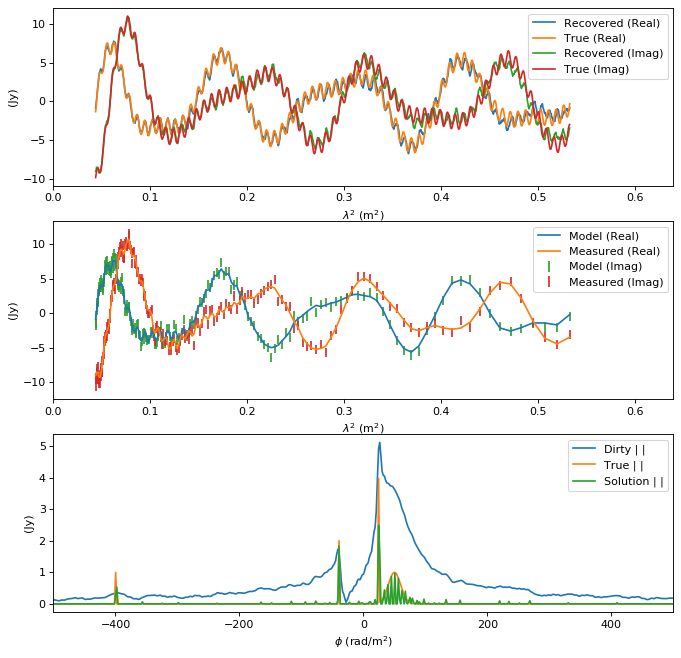

In [148]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), dpi=80)
ax[0].plot(lambda2_high_res, np.real(y_fit))
ax[0].plot(lambda2_high_res, np.real(m_op_no_averaging.dir_op(x_true)))
ax[0].plot(lambda2_high_res, np.imag(y_fit))
ax[0].plot(lambda2_high_res, np.imag(m_op_no_averaging.dir_op(x_true)))
ax[0].set_xlim([0., 0.8**2])
ax[0].set_xlabel(r"$\lambda^2$ (m$^2$)")
ax[0].set_ylabel(r"(Jy)")
ax[0].legend(["Recovered (Real)", "True (Real)", "Recovered (Imag)", "True (Imag)"])
ax[1].plot(lambda2, np.real(y_model))
ax[1].plot(lambda2, np.imag(y_model))
ax[1].errorbar(lambda2, np.real(y), yerr=lambda2*0 + sigma, fmt='',linestyle='')
ax[1].errorbar(lambda2, np.imag(y), yerr=lambda2*0 + sigma, fmt='',linestyle='')
ax[1].set_xlim([0., 0.8**2])
ax[1].set_xlabel(r"$\lambda^2$ (m$^2$)")
ax[1].set_ylabel(r"(Jy)")
ax[1].legend(["Model (Real)", "Measured (Real)", "Model (Imag)", "Measured (Imag)"])
ax[2].plot(phi, np.abs(m_op.adj_op(y)) * 1./len(y))
ax[2].plot(phi, np.abs(x_true))
ax[2].plot(phi, np.abs(solution))
ax[2].legend(["Dirty | |", "True | |", "Solution | |"])
ax[2].set_xlabel(r"$\phi$ (rad/m$^2$)")
ax[2].set_ylabel(r"(Jy)")
ax[2].set_xlim([-rm_max, rm_max])